In [1]:
#%matplotlib inline
#%reload_ext signature

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

import matplotlib.image as img
WD = os.getcwd()
print(WD)

/home/silvio/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/silvio/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/silvio/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/silvio/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/silvio/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may

/home/silvio/Dokumente/GitHub/BrainMRT


In [7]:
dataPath="./DICOM/ST000000/SE000000/"
series = [g for g in glob(WD + "/DICOM/ST000000/SE000000/*") if not os.path.isdir(g)]
print ("Total of %d DICOM images\n" % len(series))
series[:5]

Total of 128 DICOM images



['/home/silvio/Dokumente/GitHub/BrainMRT/DICOM/ST000000/SE000000/MR000096',
 '/home/silvio/Dokumente/GitHub/BrainMRT/DICOM/ST000000/SE000000/MR000067',
 '/home/silvio/Dokumente/GitHub/BrainMRT/DICOM/ST000000/SE000000/MR000101',
 '/home/silvio/Dokumente/GitHub/BrainMRT/DICOM/ST000000/SE000000/MR000058',
 '/home/silvio/Dokumente/GitHub/BrainMRT/DICOM/ST000000/SE000000/MR000028']

In [8]:
#      
# Loop over the image files and store everything into a list.
# 

def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    #intercept = scans[0].RescaleIntercept
    #slope = scans[0].RescaleSlope
    
    #if slope != 1:
    #    image = slope * image.astype(np.float64)
    #    image = image.astype(np.int16)
        
    #image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [9]:
outputPath = "./data/"
id=0
patient = load_scan(dataPath)
imgs = get_pixels_hu(patient)

np.save(outputPath + "fullimages_%d.npy" % (id), imgs)

patient[0]

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'NORM', 'DIS2D']
(0008, 0012) Instance Creation Date              DA: '20160822'
(0008, 0013) Instance Creation Time              TM: '164405.942000'
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.2.19.45227.2016082216440146278425418
(0008, 0020) Study Date                          DA: '20160822'
(0008, 0021) Series Date                         DA: '20160822'
(0008, 0022) Acquisition Date                    DA: '20160822'
(0008, 0023) Content Date                        DA: '20160822'
(0008, 0030) Study Time                          TM: '164306.047000'
(0008, 0031) Series Time                         TM: '164405.939000'
(0008, 0032) Acquisition Time                    TM: '164348.017500'
(0008, 0033) Content Time                        TM: '164405.94

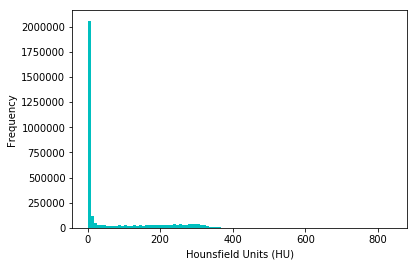

mean HU: 66.526, std HU: 108.820
median HU: 3.000, mode HU: 1.000
second max[>200]: 298.000

Gesamt 		 erkannter Anteil
air: 0.000%		 0.000%
lung: 0.000%		 0.000%
fat: 0.000%		 0.000%

Gesamt 		 erkannter Anteil
water: 0.000%		 0.000%
blood: 2.335%		 3.344%
muscle: 1.572%		 2.252%
grey Matter: 0.365%	 0.523%
White Matter: 0.436%	 0.625%
soft tissue: 63.942%	 91.584%
liver: 1.120%		 1.604%
bone: 0.048%		 0.068%
rest: 0.000%		 0.000%


In [11]:
#load data
dataMRT= outputPath + "fullimages_%d.npy" % id
images = np.load(dataMRT).astype(np.float64) 
imageFlat = images.flatten()

plt.hist(imageFlat, bins=100, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

#Substance	HU
#Air	−1000
#Lung	−500
#Fat	−100 to −50
#Water	0
#Blood	+30 to +70
#Muscle	+10 to +40
#Liver	+40 to +60
#Bone	+700 (cancellous bone) to +3000 (cortical bone)
total=imageFlat.sum()/100
#imageFlat[(imageFlat>imageFlat.min()) & (imageFlat<imageFlat.max())].sum()

from scipy import stats
print('mean HU: {:.3f}, std HU: {:.3f}\n'.format(imageFlat.mean(),imageFlat.std()) +\
       'median HU: {:.3f}, mode HU: {:.3f}\n'.format(np.median(imageFlat),float(stats.mode(imageFlat)[0])) +\
       'second max[>200]: {:.3f}\n'.format(float(stats.mode(imageFlat[imageFlat>200])[0]))
     )

airP = imageFlat[imageFlat==-1000].sum()
lungP = imageFlat[imageFlat==-500].sum()
fatP = imageFlat[(imageFlat>-100) & (imageFlat<-50)].sum()

waterP = imageFlat[(imageFlat>-1) & (imageFlat<1)].sum()
bloodP = imageFlat[(imageFlat>30) & (imageFlat<70)].sum()
muscleP = imageFlat[(imageFlat>10) & (imageFlat<40)].sum()
greyP = imageFlat[(imageFlat>37) & (imageFlat<45)].sum()
whiteP = imageFlat[(imageFlat>20) & (imageFlat<30)].sum()
liverP = imageFlat[(imageFlat>40) & (imageFlat<60)].sum()
softP = imageFlat[(imageFlat>100) & (imageFlat<300)].sum()
boneP = imageFlat[(imageFlat>700) & (imageFlat<3000)].sum()
restP = imageFlat[(imageFlat>3000) & (imageFlat<-1000)].sum()

totalP = (airP + softP + waterP + greyP + whiteP + bloodP + lungP + fatP + muscleP + liverP + boneP+ restP)/100

print('Gesamt \t\t erkannter Anteil'+'\n'+
      'air: {:.3f}%\t\t {:.3f}%\n'.format(airP/total, airP/totalP) +\
      'lung: {:.3f}%\t\t {:.3f}%\n'.format( lungP/total,lungP/totalP) +\
      'fat: {:.3f}%\t\t {:.3f}%\n'.format(fatP/total,fatP/totalP) 
     )


print('Gesamt \t\t erkannter Anteil'+'\n'+
      'water: {:.3f}%\t\t {:.3f}%\n'.format(airP/total, airP/totalP) +\
      'blood: {:.3f}%\t\t {:.3f}%\n'.format(bloodP/total, bloodP/totalP) +\
      'muscle: {:.3f}%\t\t {:.3f}%\n'.format(muscleP/total, muscleP/totalP)+\
      'grey Matter: {:.3f}%\t {:.3f}%\n'.format(greyP/total, greyP/totalP) +\
      'White Matter: {:.3f}%\t {:.3f}%\n'.format(whiteP/total, whiteP/totalP)+\
      'soft tissue: {:.3f}%\t {:.3f}%\n'.format(softP/total, softP/totalP)+\
      'liver: {:.3f}%\t\t {:.3f}%\n'.format(liverP/total, liverP/totalP) +\
      'bone: {:.3f}%\t\t {:.3f}%\n'.format(boneP/total, boneP/totalP)  +\
      'rest: {:.3f}%\t\t {:.3f}%'.format(restP/total, restP/totalP)
     )